In [1]:
# Load libraries
import sklearn
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Importing Data
chemistries_discovery=pd.DataFrame.from_csv('chemistries_git.csv')
chemistries_discovery.index=chemistries_discovery.index.astype('float64')
#check correct sample size
print (chemistries_discovery.shape)
second_genome=pd.DataFrame.from_csv('second_genome_2.csv')
second_genome.index=second_genome.index.astype('float64')
#check correct sample size
print (second_genome.shape)
discovery_mets=pd.DataFrame.from_csv('data_discovery.csv')
discovery_mets.index=discovery_mets.index.astype('float64')
#check correct sample size
print (discovery_mets.shape)
#import list of top 11 metabolites from LASSSO
top_11_=pd.DataFrame.from_csv('top_11_.csv')
top_11_=top_11_["0"].tolist()

(399, 78)
(540, 667)
(399, 663)


In [3]:
#Scale and standardize metabolites discovery
X = discovery_mets[discovery_mets.columns[0:659]]
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
print (X.shape)

(399, 659)


In [4]:
#Scale and standardize metabolites validation
vendor = second_genome[second_genome.columns[0:659]]
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=vendor.columns
vendor = scaler.fit_transform(vendor)
vendor=pd.DataFrame(data=vendor,columns=Xcolumns)
print (vendor.shape)

(540, 659)


In [5]:
#Prepare data for RF classifier
classifier=pd.DataFrame(index=discovery_mets.index,data=X.set_index(discovery_mets.index))
classifier_validation=pd.DataFrame(index=second_genome.index,data=vendor.set_index(second_genome.index))
for x in classifier.columns.tolist():
    if x not in top_11_:
        classifier.drop([x],1,inplace=True)
print(classifier.shape)
for x in classifier_validation.columns.tolist():
    if x not in top_11_:
        classifier_validation.drop([x],1,inplace=True)
print (classifier_validation.shape)
classifier['shannon_quant']=pd.qcut(discovery_mets['shannon'],4,labels=False)
classifier_validation['shannon_quant']=pd.qcut(second_genome['shannon'],4,labels=False)
a=[]
for x in classifier['shannon_quant']:
    if x==0:
        a.append(1)
    else:
        a.append(0)
classifier['shannon_quant']=a
print (classifier['shannon_quant'].sum())
classifier.drop(['shannon_quant'],1,inplace=True)
b=[]
for x in classifier_validation['shannon_quant']:
    if x==0:
        b.append(1)
    else:
        b.append(0)
classifier_validation['shannon_quant']=b
print (classifier_validation['shannon_quant'].sum())
classifier_validation.drop(['shannon_quant'],1,inplace=True)
shannon_clf = RandomForestClassifier(n_estimators=2000,
                                 criterion='entropy',
                                 bootstrap=True, oob_score=False,class_weight={0:1,1:3.5},
                                 max_features='sqrt',
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 max_depth=5,
                                 random_state=1,
                                 n_jobs=1)

(399, 11)
(540, 11)
100
135


# Running Random forest 10-fold CV on the discovery cohort

In [6]:
X = classifier.reset_index()
X.drop(['public_client_id'],1,inplace=True)
X=np.array(X)
y=np.array(a)
n_samples, n_features = X.shape


# Perform 10-fold RF CV, extract sensitivity, specificity, precision and AUCs for each test set
FOLDS=10
cv = StratifiedKFold(n_splits=10)
reversed_mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)
mean_precision=[]
pr_auc=[]
tprs = []
aucs = []
total_specificity=[]
total_sensitivity=[]
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    probas_ = shannon_clf.fit(X[train], y[train]).predict_proba(X[test])
    preds=shannon_clf.predict(X[test])
    tn, fp, fn, tp = confusion_matrix(y[test],preds).ravel()
    sensitivity=(tp/(tp+fn))
    specificity=(tn/(tn+fp))
    mean_precision.append(precision_score(y[test],preds))
    total_specificity.append(specificity)
    total_sensitivity.append(sensitivity)
    precision, recall, thresholds= precision_recall_curve(y[test], probas_[:, 1])
    lab = 'Fold %d PR AUC=%.4f' % (i+1, auc(recall, precision))
    pr_auc.append(auc(recall, precision))
    print (lab)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    reversed_recall = np.fliplr([recall])[0]
    reversed_precision = np.fliplr([precision])[0]
    reversed_mean_precision += interp(mean_recall, reversed_recall, reversed_precision)
    reversed_mean_precision[0] = 0.0
    tprs[-1][0]=0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1
reversed_mean_precision /= FOLDS
reversed_mean_precision[0] = 1
mean_tpr_discovery = np.mean(tprs, axis=0)
mean_tpr_discovery[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr_discovery)
print ('mean sensitivity discovery',np.mean(total_sensitivity))
print ('mean specificity discovery',np.mean(total_specificity))
print ('mean precision discovery',np.mean(mean_precision))
print ('mean PR AUC',np.mean(pr_auc))
print ('std dev.',np.std(pr_auc))
print ('mean ROC AUC',np.mean(aucs))
print ('std_dev ROC AUC',np.std(aucs))

Fold 1 PR AUC=0.8054
Fold 2 PR AUC=0.5833
Fold 3 PR AUC=0.8264
Fold 4 PR AUC=0.6564
Fold 5 PR AUC=0.8055
Fold 6 PR AUC=0.6580
Fold 7 PR AUC=0.8190
Fold 8 PR AUC=0.8111
Fold 9 PR AUC=0.8450
Fold 10 PR AUC=0.7892
mean sensitivity discovery 0.72
mean specificity discovery 0.9031034482758621
mean precision discovery 0.7206313131313131
mean PR AUC 0.7599295308547271
std dev. 0.08665212426781399
mean ROC AUC 0.8840689655172413
std_dev ROC AUC 0.044473556326354025


# Running Random forest 10-fold CV on the validation cohort

In [7]:
# Perform 10-fold CV RF classification on the validation set, extract performance metrics for each out-of-sample set
X = classifier_validation.reset_index()
X.drop(['public_client_id'],1,inplace=True)
X=np.array(X)
y=np.array(b)
n_samples, n_features = X.shape

FOLDS=10
cv = StratifiedKFold(n_splits=10)
val_reversed_mean_precision = 0.0
val_mean_recall = np.linspace(0, 1, 100)
mean_precision=[]
pr_auc=[]
tprs = []
aucs = []
total_specificity=[]
total_sensitivity=[]
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train, test in cv.split(X, y):
    probas_ = shannon_clf.fit(X[train], y[train]).predict_proba(X[test])
    preds=shannon_clf.predict(X[test])
    tn, fp, fn, tp = confusion_matrix(y[test],preds).ravel()
    sensitivity=(tp/(tp+fn))
    specificity=(tn/(tn+fp))
    mean_precision.append(precision_score(y[test],preds))
    total_specificity.append(specificity)
    total_sensitivity.append(sensitivity)
    precision, recall, thresholds= precision_recall_curve(y[test], probas_[:, 1])
    lab = 'Fold %d PR AUC=%.4f' % (i+1, auc(recall, precision))
    pr_auc.append(auc(recall, precision))
    print (lab)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    reversed_recall = np.fliplr([recall])[0]
    reversed_precision = np.fliplr([precision])[0]
    val_reversed_mean_precision += interp(val_mean_recall, reversed_recall, reversed_precision)
    val_reversed_mean_precision[0] = 0.0
    tprs[-1][0]=0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1
val_reversed_mean_precision /= FOLDS
val_reversed_mean_precision[0] = 1
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
std_auc = np.std(aucs)
print ('Validation mean sensitivity',np.mean(total_sensitivity))
print ('Validation mean specificity',np.mean(total_specificity))
print ('Validation mean precision',np.mean(mean_precision))
print ('mean PR AUC',np.mean(pr_auc))
print ('std_dev PR AUC',np.std(pr_auc))
print ('mean ROC AUC',np.mean(aucs))
print ('std_dev ROC AUC',np.std(aucs))

Fold 1 PR AUC=0.6646
Fold 2 PR AUC=0.6953
Fold 3 PR AUC=0.5521
Fold 4 PR AUC=0.8411
Fold 5 PR AUC=0.4499
Fold 6 PR AUC=0.8148
Fold 7 PR AUC=0.6656
Fold 8 PR AUC=0.6835
Fold 9 PR AUC=0.5826
Fold 10 PR AUC=0.7024
Validation mean sensitivity 0.651098901098901
Validation mean specificity 0.869329268292683
Validation mean precision 0.643225238813474
mean PR AUC 0.6651764096452646
std_dev PR AUC 0.11041580011801376
mean ROC AUC 0.81774457250067
std_dev ROC AUC 0.06996473620780753


# Plot ROC Curves for Discovery and Validation (FIGURE 6D)

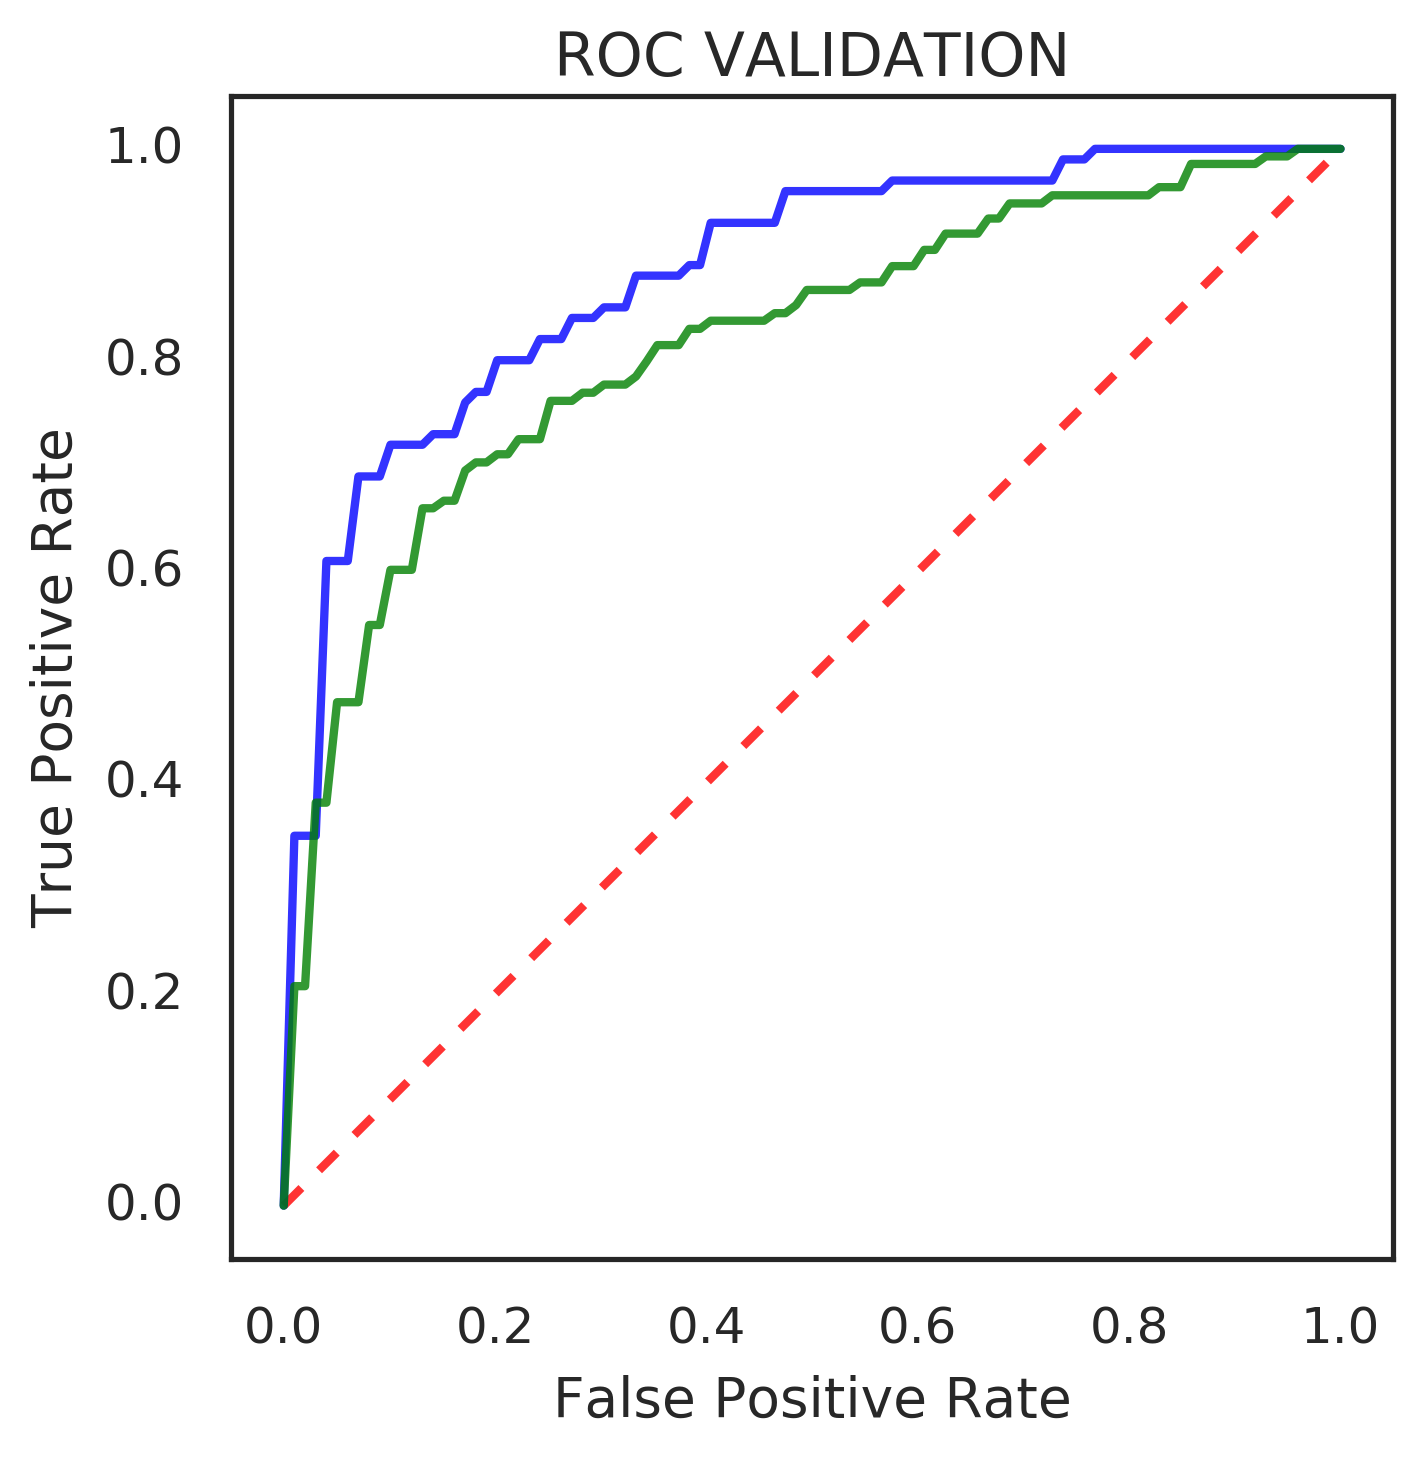

In [8]:
sns.set(font_scale=.750,context='poster',font='Arial',style='white')
std_auc = np.std(aucs)
plt.figure(figsize=(5,5), dpi=300)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         alpha=.8)
plt.plot(mean_fpr, mean_tpr_discovery, color='b',
         lw=2, alpha=.8)
plt.plot(mean_fpr, mean_tpr, color='g',
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC VALIDATION')
plt.legend(loc="lower right")

# Plot PR Curves for Discovery and Validation (FIGURE 6E)

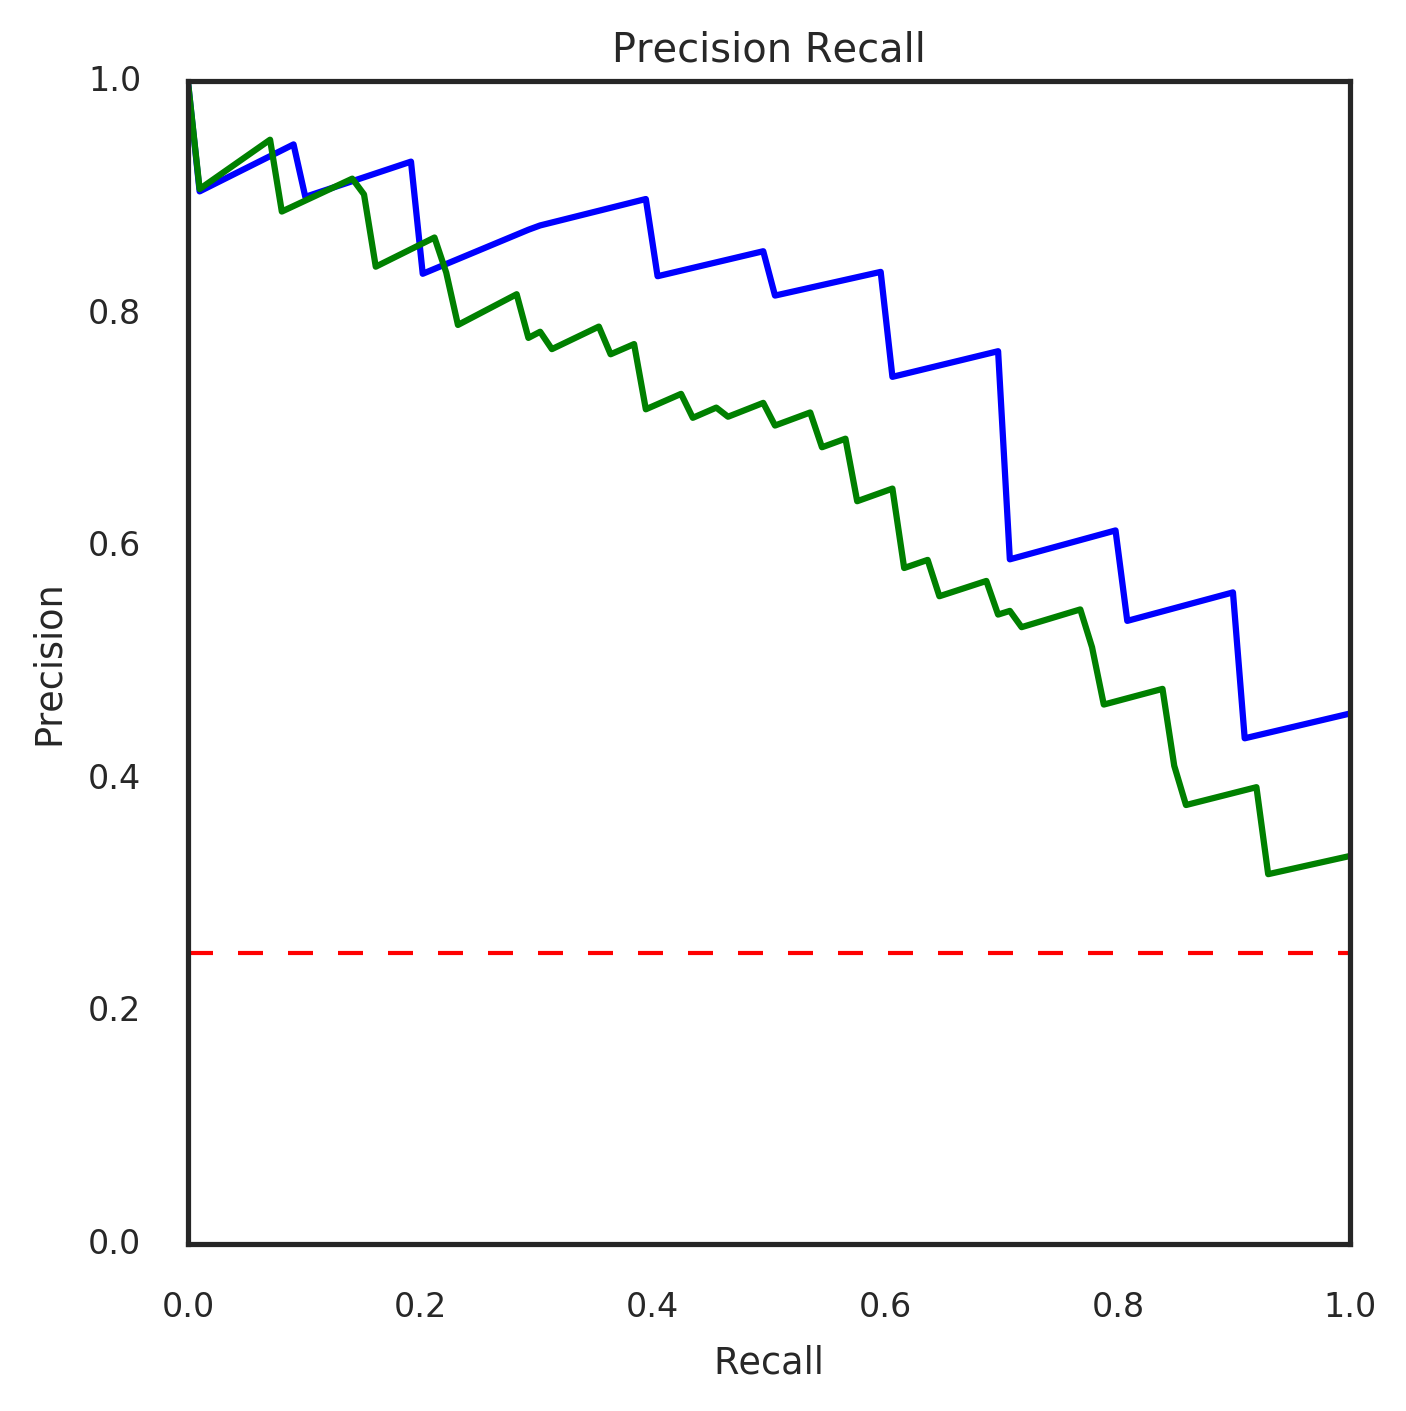

In [9]:
plt.figure(figsize=(5,5), dpi=300)
sns.set(font_scale=.5,context='poster',font='Arial',style='white')
mean_auc_pr = auc(mean_recall, reversed_mean_precision)
val_auc_pr=auc(val_mean_recall,val_reversed_mean_precision)
#clinical_auc_pr = auc(clinical_mean_recall, clinical_reversed_mean_precision)
plt.plot(mean_recall,  ([reversed_mean_precision])[0], 'b',
          lw=1.5)
plt.plot(val_mean_recall,  ([val_reversed_mean_precision])[0], 'g',
         lw=1.5)
#plt.plot(clinical_mean_recall,  ([clinical_reversed_mean_precision])[0], 'k',
#         label='Mean precision clinical labs(area = %0.2f)' % clinical_auc_pr, lw=1.5)
plt.hlines(0.25, 0, 1, colors='r', linestyles='--', label='',lw=1)
#plt.plot([1,0], [0,1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall')
plt.legend(loc="lower right")
plt.show()

# Assessing Predictive Capacity of Clinical Labs

(399, 77)


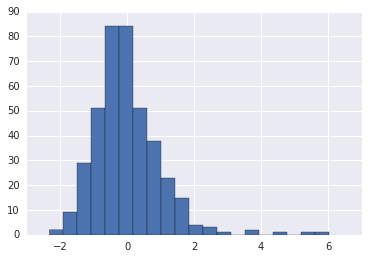

In [10]:
#Assessing classification capacity of clinical labs
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
C = chemistries_discovery.loc[:,chemistries_discovery.columns!='shannon']
y = chemistries_discovery['shannon']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Ccolumns=C.columns
C = scaler.fit_transform(C)
C=pd.DataFrame(data=C,columns=Ccolumns)
print (C.shape)
sns.set(font_scale=1.00)
C[C.columns[4]].hist(bins=20)

In [11]:
#Classifying participants in bottom quartile of shannon using 77 clinical labs
classifier_chem=pd.DataFrame(index=discovery_mets.index,data=C.set_index(discovery_mets.index))
classifier_chem['shannon_quant']=pd.qcut(chemistries_discovery['shannon'],4,labels=False)
c=[]
for x in classifier_chem['shannon_quant']:
    if x==3:
        c.append(1)
    else:
        c.append(0)
classifier_chem['shannon_quant']=c
print (classifier_chem['shannon_quant'].sum())
classifier_chem.drop(['shannon_quant'],1,inplace=True)
print (classifier_chem.shape)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
shannon_clf = RandomForestClassifier(n_estimators=2000,
                                 criterion='entropy',
                                 bootstrap=False, oob_score=False,class_weight={0:1,1:3.5},
                                 max_features='sqrt',
                                 min_samples_split=3,
                                 min_samples_leaf=3,
                                 max_depth=5,
                                 random_state=1,
                                 n_jobs=1)

100
(399, 77)


In [12]:
X = classifier_chem.reset_index()
X.drop(['public_client_id'],1,inplace=True)
X=np.array(X)
y=np.array(c)
n_samples, n_features = X.shape

cv = StratifiedKFold(n_splits=10)
clinical_reversed_mean_precision = 0.0
clinical_mean_recall = np.linspace(0, 1, 100)
features=pd.DataFrame(index=C.columns)
mean_precision=[]
pr_auc_clinical=[]
tprs = []
aucs = []
total_specificity=[]
total_sensitivity=[]
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = shannon_clf.fit(X[train], y[train]).predict_proba(X[test])
    features[i]=list(shannon_clf.feature_importances_)
    preds=shannon_clf.predict(X[test])
    tn, fp, fn, tp = confusion_matrix(y[test],preds).ravel()
    sensitivity=(tp/(tp+fn))
    specificity=(tn/(tn+fp))
    mean_precision.append(precision_score(y[test],preds))
    total_specificity.append(specificity)
    total_sensitivity.append(sensitivity)
    precision, recall, thresholds= precision_recall_curve(y[test], probas_[:, 1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    pr_auc_clinical.append(auc(recall, precision))
    print (lab)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    reversed_recall = np.fliplr([recall])[0]
    reversed_precision = np.fliplr([precision])[0]
    clinical_reversed_mean_precision += interp(mean_recall, reversed_recall, reversed_precision)
    clinical_reversed_mean_precision[0] = 0.0
    tprs[-1][0]=0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1
clinical_reversed_mean_precision/= FOLDS
clinical_reversed_mean_precision[0] = 1
mean_tpr_chemistries = np.mean(tprs, axis=0)
mean_tpr_chemistries[-1] = 1.0
print ('precision',np.mean(mean_precision))
print ('specificity',np.mean(total_specificity))
print ('sensitivity',np.mean(total_sensitivity))
print ('pr_AUC',np.mean(pr_auc_clinical))

Fold 1 AUC=0.4969
Fold 2 AUC=0.2612
Fold 3 AUC=0.3257
Fold 4 AUC=0.2891
Fold 5 AUC=0.2822
Fold 6 AUC=0.5034
Fold 7 AUC=0.5299
Fold 8 AUC=0.5027
Fold 9 AUC=0.5814
Fold 10 AUC=0.2726
precision 0.3753034547152194
specificity 0.7493103448275862
sensitivity 0.48
pr_AUC 0.4044980357533623


# Generating Supplementary Figure 3

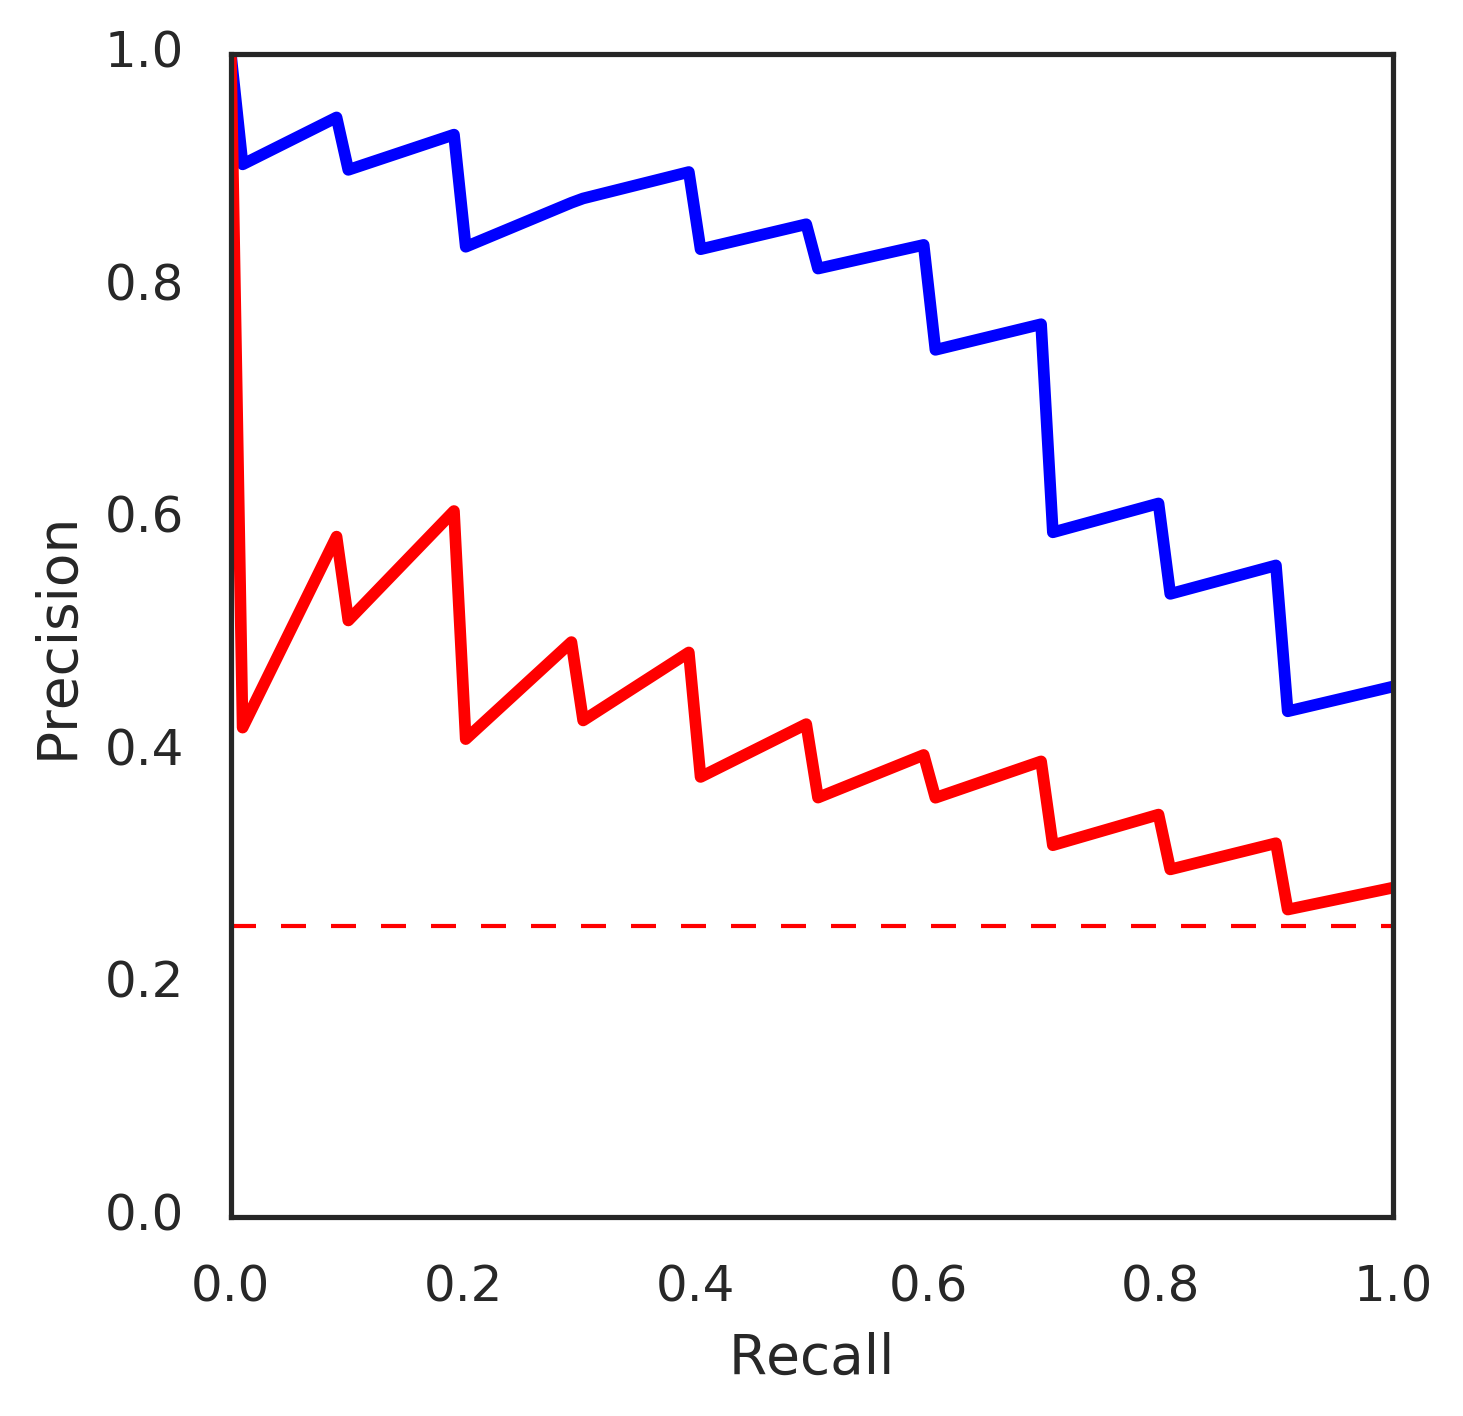

In [13]:
plt.figure(figsize=(5,5), dpi=300)
sns.set(font_scale=.75,context='poster',font='Arial',style='white')
mean_auc_pr_clinical = np.mean(pr_auc_clinical)
#clinical_auc_pr = auc(clinical_mean_recall, clinical_reversed_mean_precision)
plt.plot(mean_recall,  ([reversed_mean_precision])[0], 'b')
plt.plot(clinical_mean_recall,  ([clinical_reversed_mean_precision])[0], 'r')
#plt.plot(clinical_mean_recall,  ([clinical_reversed_mean_precision])[0], 'k',
#         label='Mean precision clinical labs(area = %0.2f)' % clinical_auc_pr, lw=1.5)
plt.hlines(0.25, 0, 1, colors='r', linestyles='--', label='',lw=1)
#plt.plot([1,0], [0,1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.show()
plt.savefig('precision-recall.png',dpi=200)